# TP final : Identification de vêtements à travers la classification d'images

## Par : Abdelhakim Benechehab & Younes Gueddari

## Démarche

Le problème est assez compliqué dans son début, notre jeu de données est composé d'images (vu comme des matrices par python) et non pas des characteristiques prêtes à être envoyées à travers un modèle d'apprentissage statistique.

L'intuition nous guide directement vers un réseau de neurones convolutif vu qu'il est conçu pour être appliqué sur des images en utilisant des filtres pouvant en tirer des characteristiques, mais on ne va aborder cela qu'on second temps dans notre démarche.

Une premier essay de classification sera réalisé sur des données (features) retirées de notre jeu d'images, on a pu réaliser du pré-traitement sur nos images afin d'en tirer quelques characteristiques pouvant séparer entre les différentes catégories de vêtements.

Voyons voir ce que ca donne :

## pré-traitement des images :

tout d'abord voila un tas de bibliothèques qu'on va utiliser par la suite :

In [41]:
# sauvegarder et charger des workspaces python
from __future__ import print_function
import pickle

import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

#librairies relatives au traitement d'images
import cv2
import skimage.measure as sm

import pandas as pd

On va charger nos données par la suite et en visualiser un morceau avec son étiquetage : 

In [42]:
# chargement:
with open('C:/Users/Asus 6eme/Documents/Data/TP3-Final-cnn/dataset_TP3.pkl','rb') as f:train_images, train_labels = pickle.load(f)

6


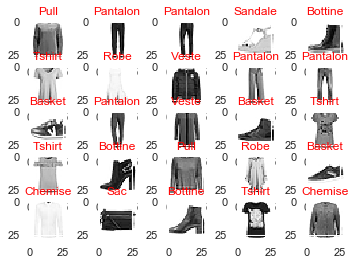

In [43]:
print(train_labels[8542])
class_names = ['Tshirt', 'Pantalon', 'Pull', 'Robe', 'Veste',
               'Sandale', 'Chemise', 'Basket', 'Sac', 'Bottine']

#affichage d'un morceau du jeu de données
fig=plt.figure()
n=2175
for i in range(n,n+25):
    a=fig.add_subplot(5,5,i-n+1)
    a.set_title(class_names[train_labels[i]],color='red')
    plt.imshow(train_images[i],cmap='Greys')
plt.show()

Le premier traitement qu'on va faire c'est de binariser nos images, nous avons hésité avant de le faire mais on a décidé de foncer malgré l'importante perte d'informations vu que c'est le seul moyen pour faire des mesures sur ces images.

Cette étape est assez conséquente sur la rugosité de nos classifieurs par la suite vu qu'elle enlève une partie considérable de l'information, mais on va la tenter quand même :

In [44]:
#on va binariser les images 
for i in range(60000):
    #le threshold utilisé est choisi judicieusement en analysant quelques images
    train_images[i]=1.0 * (train_images[i] > 16)
    #inversion de l'image pour obtenir le bon objet mesuré par la suite
    train_images[i] = abs(train_images[i]-1)

Visualisons le même morceau d'images après traitement :

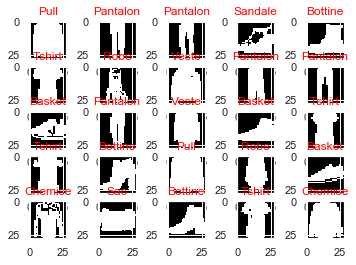

In [45]:
fig=plt.figure()
n=2175
for i in range(n,n+25):
    a=fig.add_subplot(5,5,i-n+1)
    a.set_title(class_names[train_labels[i]],color='red')
    plt.imshow(train_images[i],cmap='Greys')
plt.show()

Ensuite on va utiliser la fonction regionprops pour mesurer quelques characteristiques sur nos images dans l'espoir que cela va servir à les séparer (les mesures faites sont arbitraires, si il nous reste du temps on essayera d'en choisir les meilleurs descripteurs pour optimiser notre classifieur)

Le code suivant prend un temps considérable

In [46]:
#On va maintenant décrire nos images à l'aide de la fonction regionprops
imgdata=np.zeros((60000,9))
for i in range(60000):
    props = sm.regionprops_table(train_images[i], properties=['area', 'bbox_area','convex_area','eccentricity','equivalent_diameter','extent','major_axis_length','minor_axis_length','perimeter'])
    imgdata[i][0]=float(props['area'])
    imgdata[i][1]=float(props['bbox_area'])
    imgdata[i][2]=float(props['convex_area'])
    imgdata[i][3]=float(props['eccentricity'])
    imgdata[i][4]=float(props['equivalent_diameter'])
    imgdata[i][5]=float(props['extent'])
    imgdata[i][6]=float(props['major_axis_length'])
    imgdata[i][7]=float(props['minor_axis_length'])
    imgdata[i][8]=float(props['perimeter'])


Maintenant pour ne pas utiliser toutes ces characteristiques, on va faire une 'feature selection' à l'aide de scikit learn, on ne va garder que les 5 meilleurs features parmi les neuf qu'on a maintenant.

La feature selection se base sur des techniques d'analyse de variance des différentes variables.

En voici l'implementation :

In [49]:
#On va essayer maintenant d'éliminer les mauvaises characteristiques
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#On va selectionner les 5 meilleures features
imgdata_new = SelectKBest(chi2, k=5).fit_transform(imgdata, train_labels)

#On n'a pas rentré dans les détails mais la métrique du chi2 est adéquate pour un problème de classification

#On va maintenant convertir nos données input en dataframe
df = pd.DataFrame(imgdata_new, columns=['feature1', 'feature2','feature3','feature4','feature5'])

#Ca influence pas le warning qui suit ^^


C:\Anaconda\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


## Premiers modèles basés sur le traitement d'image

La suite est inspirée du Notebook sur la librairie Scikit-learn, on va utiliser la même procédure mais avec des méthodes de classification cette fois et qui sont assez nombreuses dans scikit learn, on a choisi 7 méthodes pour pouvoir les comparer :

In [50]:
# On sépare les données en entrainement et test
X_train, X_test, y_train, y_test = train_test_split(df, train_labels, test_size = 0.25)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(45000, 5) (45000,)
(15000, 5) (15000,)


toujours des importations :

In [51]:
import seaborn as sns; sns.set()

import sklearn.tree
import sklearn.neighbors
from sklearn.svm import SVC # "Support Vector Classifier"
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import neural_network

#celui-ci non plus ^^

On va ensuite définir nos modèles, les entrainer et faire la prédiction sur nos données tests :
Le temps de calcul est assez élevé (20 min)

In [52]:
# On va définir plusieurs modèles pour voir lequel est le meilleur
logistic_m = LogisticRegression() #régression logistique
tree_m = sklearn.tree.DecisionTreeClassifier(max_depth=3) #arbre de décision
gradient_descent_m=SGDClassifier()# stochastic gradient descent
gradient_boosting_m=GradientBoostingClassifier()# gradient boosting
knn_m = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3) #k nearest neighbors
svm_m = SVC(kernel='linear') # Support Vector Classifier (inspiré du SVM)
neural_net_m = sklearn.neural_network.MLPClassifier(
    hidden_layer_sizes=(8,2),  activation='relu', solver='adam', alpha=0.002, batch_size='auto',
    learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=2000, shuffle=True,
    random_state=9, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
    early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08) #Réseau de neurones, on a ici spécifié tous les paramètres du réseau (possible avec n'importe quel modèle)


#on entraine nos modèles avec la méthode .fit()
model1 = logistic_m.fit(X_train, y_train)
model2 = tree_m.fit(X_train, y_train)
model3 = gradient_descent_m.fit(X_train, y_train)
model4 = gradient_boosting_m.fit(X_train, y_train)
model5 = knn_m.fit(X_train, y_train)
model6 = svm_m.fit(X_train, y_train)
model7 = neural_net_m.fit(X_train, y_train)


# les prédictions s'effectuent simplement avec la méthode .predict()
predictions1 = logistic_m.predict(X_test)
predictions2 = tree_m.predict(X_test)
predictions3 = gradient_descent_m.predict(X_test)
predictions4 = gradient_boosting_m.predict(X_test)
predictions5 = knn_m.predict(X_test)
predictions6 = svm_m.predict(X_test)
predictions7 = neural_net_m.predict(X_test)

Le critère qu'on a choisi pour évaluer nos modèles est le calcul de l'accuracy vu que toutes les classes sont symétriques :

['Logitic regression', 0.5682666666666667]
['Decision tree', 0.46486666666666665]
['Gradient descent', 0.27126666666666666]
['Gradient boosting', 0.6496666666666666]
['Knn', 0.5503333333333333]
['SVM', 0.6166666666666667]
['Neural network', 0.29033333333333333]


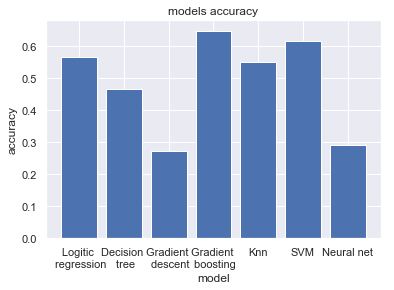

In [53]:
#On calcule l'accuracy et l'erreur pour chaque modèle
from sklearn.metrics import accuracy_score

accuracy1 = accuracy_score(y_test,predictions1)
accuracy2 = accuracy_score(y_test,predictions2)
accuracy3 = accuracy_score(y_test,predictions3)
accuracy4 = accuracy_score(y_test,predictions4)
accuracy5 = accuracy_score(y_test,predictions5)
accuracy6 = accuracy_score(y_test,predictions6)
accuracy7 = accuracy_score(y_test,predictions7)

print(['Logitic regression',accuracy1])
print(['Decision tree',accuracy2])
print(['Gradient descent',accuracy3])
print(['Gradient boosting',accuracy4])
print(['Knn',accuracy5])
print(['SVM',accuracy6])
print(['Neural network',accuracy7])

#Graphe d'accuracy
fig=plt.figure()
plt.bar([1,2,3,4,5,6,7],height=[accuracy1,accuracy2,accuracy3,accuracy4,accuracy5,accuracy6,accuracy7],tick_label=['Logitic \n regression', 'Decision \n tree', 'Gradient \n descent', 'Gradient \n boosting', 'Knn', 'SVM', 'Neural net'])
plt.title('models accuracy')
plt.ylabel('accuracy')
plt.xlabel('model')
plt.show()

Les résultats obtenus sont pas mal par rapport à la légereté de l'approche, on a pu atteindre une accuracy de 65% avec le modèle du Gradient Boosting ce qui peut suffire pour convaincre nos clients, en voila un échantillon (bleu pour les bonnes prédictions et rouge sinon) :

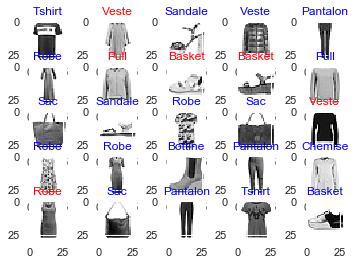

In [57]:
# chargement:
with open('C:/Users/Asus 6eme/Documents/Data/TP3-Final-cnn/dataset_TP3.pkl','rb') as f:train_images, train_labels = pickle.load(f)

#visualisation d'un échantillon des données tests avec ses labels prédites
indexes = X_test.index
fig=plt.figure()
for i in range(0,25):
    a=fig.add_subplot(5,5,i+1)
    
    if predictions4[i] == y_test[i]:
        col='blue'
    else:
        col= 'red'
    
    a.set_title(class_names[predictions4[i]],color=col)
    plt.imshow(train_images[indexes[i]],cmap='Greys')
plt.show()

C'est quand même honteux de montrer cela au CEO alors qu'il pourrait être bien meilleur.

Ainsi cette démarche de classification peu rigoureuse et très hasardeuse peut être une alternative pour l'identification des vêtements mais au point d'être industrialisée. Cela revient au fait que les pré-traitements réalisés sur ces images nous ont fait perdre de l'information ainsi que le pré-choix des descripteurs qui était peut-être pas le bon. 

Dans la suite on va essayer un réseau de neurones convolutif en espérant que ce serait meilleur que cette modeste première approche :')

## Utilisation d'un réseau de neurones convolutif à l'aide de Tensorflow

Passons maintenant qux choses sérieuses!! 
Les importations nécessaires :

In [19]:
from __future__ import print_function
import pickle

import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import to_categorical

On va reimporter notre base de données :

In [3]:
# chargement:
with open('C:/Users/Asus 6eme/Documents/Data/TP3-Final-cnn/dataset_TP3.pkl','rb') as f:train_images, train_labels = pickle.load(f)

On va séparer nos données en 3 parties cette fois-ci; un ensemble d'apprentissage, un ensemble de test et un dernier de validation

In [4]:
# On sépare les données en entrainement et test
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size = 0.15)

#Puis encore en validation set
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.1)

Pour pouvoir utiliser le réseau de neurones il faut ajuster le format de nos données d'entrée (input), il faut bien préciser les trois dimensions de nos images (28*28*1 dans notre cas -image à tons de gris-) 

In [15]:
input_shape = (28, 28, 1)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('X_validation shape: ', X_validation.shape)

X_train shape:  (45900, 28, 28, 1)
X_test shape:  (9000, 28, 28, 1)
X_validation shape:  (5100, 28, 28, 1)


Nous sommes dans un problème de classification, il faut donc définir notre cible comme des catégories :

In [16]:
y_train_categ = to_categorical(y_train, num_classes=10, dtype='float32') 

Maintenant on va définir notre modèle, pour cela on a essayé plusieurs alternatives pour optimiser l'accuracy de notre modèle est donc ce qui suit sont les paramètres optimales qu'on a utilisé à la fin : (temps de calcul important sur CPU, environ 30min)

In [20]:
#Sequential pour concatener les couches qu'on va ajouter par la suite
model = Sequential()

#Première couche convolutive avec 32 filtre 3*3
model.add(Conv2D(32, (3, 3), padding="same", kernel_regularizer=l2(0.01), input_shape=input_shape))
model.add(Activation("relu"))

# L'ajout de la Batch normalization permet de limiter le changement dans la distribution des valeurs d'entrée 
#dans un algorithme d'apprentissage (Covariate shift).
# Ceci se fait en normalisant les activations de chaque couche (transformant les entrées en moyenne = 0 et variance = 1). 
#Ceci, permet à chaque couche d’apprendre sur une distribution d’entrées plus stable, ce qui accélérerait la formation du réseau.
model.add(BatchNormalization(axis=-1))

#Réduction de dimension en sélectionnant le Max sur chaque fenêtre 2*2
model.add(MaxPooling2D(pool_size=(2, 2)))
#ce Dropout enlève 1/4 des output de la dernière couche afin d'éviter l'overfitting
model.add(Dropout(0.25))

#On applati no couches
model.add(Flatten())

#On ajoute une couche Dense normale avec 128 neurones puis un dropout d'un tiers
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.3))

#Et finalement une couche normale avec le nombre d'outputs le nombre de classes qu'on a
num_classes = 10
model.add(Dense(num_classes))
model.add(Activation("softmax"))

Après de nombreux essais seulement qu'on s'est décidé sur ce modèle qui est peut-être peu intuitif.
La prochaine étape est de compiler notre modèle en choissisant un bon optimiseur et les métriques voulues:

In [21]:
lr = 0.001
opt = Adam(lr=lr, beta_1=0.9, beta_2=0.999)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Il ne reste plus qu'à faire apprendre notre modèle en prenant les bons paramètres

In [ ]:
batch_size = 128
epochs = 15

# cette fonction permet d'arrêter l'entrainement s'il tagne
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) 

apprentissage=model.fit(X_train.astype("float32"), y_train_categ,
              batch_size=batch_size,
              epochs=epochs,
              verbose=0,
              validation_data=(X_test, to_categorical(y_test)),
              shuffle=True,
              callbacks=[early_stop])# c'est ici que l'on lance l'entrainement de notre modèle. Si c'est un gros modèle, vous pouvez avoir interet à le faire tourner sur GPU

Visualisation des résultats :

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
{'loss': [0.5666181849939891, 0.38562088968187636, 0.33703647376015816, 0.3084493176454033, 0.2859170843183605, 0.2727176679596143, 0.26229198353612604, 0.2473654097123863, 0.2427060688671723, 0.23531730814696916, 0.2279270990923339, 0.22045390857200997], 'accuracy': [0.80795205, 0.86376905, 0.880305, 0.8888889, 0.8953377, 0.9003922, 0.9038344, 0.9096732, 0.91050106, 0.9122222, 0.9167538, 0.91908497], 'val_loss': [0.36506269523832535, 0.30735340049531723, 0.2903827035559548, 0.2777736276653078, 0.27031980778111353, 0.28435540575451324, 0.2822751025226381, 0.25890707079569497, 0.2537639222277535, 0.2601202168862025, 0.27001949025524985, 0.260393867943022], 'val_accuracy': [0.86788887, 0.89122224, 0.8988889, 0.9031111, 0.90511113, 0.89977777, 0.902, 0.91044444, 0.91033334, 0.91366667, 0.9108889, 0.91444445]}


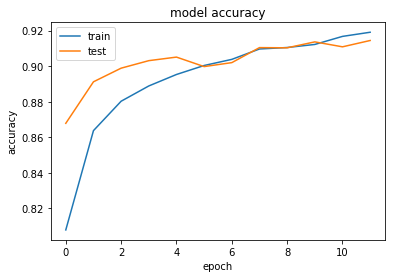

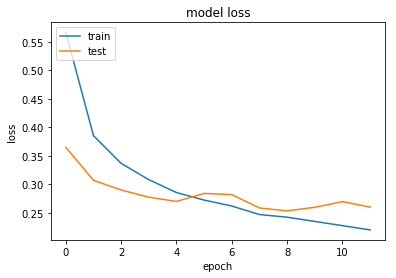

In [23]:
print(apprentissage.history.keys())
print(apprentissage.history)

fig=plt.figure()
plt.plot(apprentissage.history['accuracy'])
plt.plot(apprentissage.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# summarize history for loss
fig=plt.figure()
plt.plot(apprentissage.history['loss'])
plt.plot(apprentissage.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Et enfin on va tester notre modèle sur l'ensemble de validation :

Validation loss: 0.26427357732080947
Validation accuracy: 0.91431373


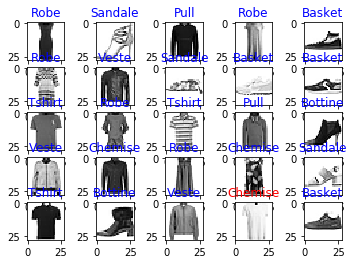

In [24]:
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2],1)
resultats = model.evaluate(X_validation, to_categorical(y_validation), verbose=0)
print('Validation loss:', resultats[0])
print('Validation accuracy:', resultats[1])

predictions = model.predict(X_validation.astype("float32"))

class_names = ['Tshirt', 'Pantalon', 'Pull', 'Robe', 'Veste',
               'Sandale', 'Chemise', 'Basket', 'Sac', 'Bottine']
               
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2])

fig=plt.figure()
for i in range(50,75):
    a=fig.add_subplot(5,5,i-50+1)
    t=predictions[i,:]
    
    if np.argmax(t) == y_validation[i]:
        col='blue'
    else:
        col= 'red'
    
    a.set_title(class_names[np.argmax(t)],color=col)
    plt.imshow(X_validation[i],cmap='Greys')
plt.show()

Sur cet échantillon de 25 images notre modèle a eu presque tout juste, ainsi on a de quoi convaincre le CEO par notre approche ;)

Il faut bien remarquer que l'output de la méthode predict sur notre modèle est sous forme de vecteurs de taille 10 pour chaque image rentrée, ce vecteur contient les probabilités d'appartenance de cette image à chacune des 10 classes, ainsi on peut visualiser un diagramme de probabilités d'appartenance pour chaque image.

In [25]:
print('Predictions: ', predictions.shape)

Predictions:  (5100, 10)


Essayons d'implementer cela : 
En rouge ces les vrais labels et en bleu c'est les prédictions, les pourcentages d'appartenances aux autres classes sont en gris. l'écriture s'affiche en bleu si la pédiction est bonne, et en rouge sinon.

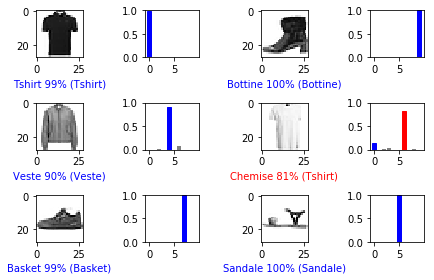

In [32]:
fig=plt.figure()
k=0
for i in range(70,76):
    plt.subplot(3, 4, 2*k+1)
    plt.imshow(X_validation[i],cmap='Greys')
    
    t=predictions[i,:]
    
    if np.argmax(t) == y_validation[i]:
        col='blue'
    else:
        col= 'red'
    plt.xlabel(class_names[np.argmax(t)]+' '+str(int(100*np.max(t)))+'% ('+class_names[y_validation[i]]+')',color=col)  
        
    plt.subplot(3, 4, 2*k+2)
    bar = plt.bar(range(10), t, color='grey')
    plt.ylim([0, 1])
    
    bar[np.argmax(t)].set_color('red')
    bar[y_validation[i]].set_color('blue')
    k=k+1
plt.tight_layout()
plt.show()

Merci.

Réalisé par : Abdelhakim Benechehab et Younes Gueddari